In [2]:
import dlib
import os
from PIL import Image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [4]:
import zipfile
path = '/content/drive/MyDrive/Datasets/yalefaces.zip'
zip_object = zipfile.ZipFile(file=path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [5]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('/content/drive/MyDrive/Weights/shape_predictor_68_face_landmarks.dat')
face_descriptor_extractor = dlib.face_recognition_model_v1('/content/drive/MyDrive/Weights/dlib_face_recognition_resnet_model_v1.dat')

In [6]:
index = {}
idx=0
face_descriptors = None

paths = [os.path.join('/content/yalefaces/train',f) for f in os.listdir('/content/yalefaces/train')]
for path in paths:
  # print(path)
  image = Image.open(path).convert('RGB')
  image_np = np.array(image,'uint8')
  face_detection = face_detector(image_np,1)
  for face in face_detection:
    l,t,r,b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np,(l,t),(r,b),(0,0,255),2)
    points = points_detector(image_np,face)
    for point in points.parts():
      cv2.circle(image_np,(point.x, point.y),2,(0,255,0),1)
    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np,points)
    face_descriptor = [f for f in face_descriptor]
    face_descriptor = np.array(face_descriptor,dtype=np.float64)
    face_descriptor = face_descriptor[np.newaxis, :]
    # print(face_descriptor)
    if face_descriptors is None:
      face_descriptors = face_descriptor
    else:
      face_descriptors = np.concatenate((face_descriptors,face_descriptor),axis=0)

    index[idx] = path 
    idx += 1      

  # cv2_imshow(image_np)  


In [19]:
face_descriptors.shape

(132, 128)

In [20]:
face_descriptors

array([[-0.15016598,  0.08190971, -0.00158949, ..., -0.02205639,
         0.11158851,  0.05841742],
       [-0.16750331,  0.04092948,  0.07239178, ...,  0.02982324,
         0.11341026,  0.05801933],
       [-0.09758417,  0.01798972, -0.09853616, ..., -0.00577495,
        -0.01994056,  0.06262899],
       ...,
       [-0.1402103 ,  0.07552125,  0.01510925, ...,  0.01090842,
         0.06845607,  0.0286531 ],
       [-0.20720418,  0.09235502,  0.05147153, ..., -0.03726506,
         0.0900088 ,  0.06165224],
       [-0.12021624,  0.11514573,  0.08716735, ..., -0.02592804,
         0.18188372,  0.00609227]])

In [7]:
np.linalg.norm(face_descriptors[131]-face_descriptors[130])

0.8342713128797209

In [8]:
np.linalg.norm(face_descriptors[131]-face_descriptors[129])

0.8688091416605084

In [9]:
np.linalg.norm(face_descriptors[131]-face_descriptors[128])

0.8217703878181023

In [10]:
np.linalg.norm(face_descriptors[131]-face_descriptors, axis=1)

array([0.76400487, 0.79178752, 0.95649556, 0.62123555, 0.78258176,
       0.86599835, 0.92052061, 0.59698965, 0.76194778, 0.57233887,
       0.66489587, 0.80980989, 0.8381932 , 0.83245882, 0.6559955 ,
       0.46361575, 0.9067689 , 0.88818831, 0.75961726, 0.90873356,
       0.89490924, 0.80443262, 0.55282672, 0.80348499, 0.897523  ,
       0.93304279, 0.50080194, 0.82819846, 0.80812139, 0.76978965,
       0.87601678, 0.80234189, 0.88995973, 0.518422  , 0.79168658,
       0.89894142, 0.59244871, 0.87388178, 0.76818003, 0.79828147,
       0.93035231, 0.80385084, 0.83400336, 0.94321238, 0.84113372,
       0.75961726, 0.79383459, 0.51749106, 0.90686047, 0.77587148,
       0.59543549, 0.8502281 , 0.81755132, 0.67245045, 0.87425808,
       0.7484544 , 0.85653727, 0.79515514, 0.84265979, 0.83655308,
       0.50987103, 0.87975626, 0.60238677, 0.90353108, 0.66051288,
       0.81521283, 0.8335708 , 0.32223582, 0.86176956, 0.79547124,
       0.83339249, 0.91671219, 0.85036256, 0.87425808, 0.42748

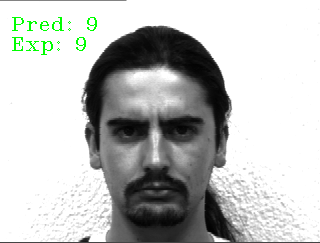

In [24]:
threshold = 0.5
predictions = []
expected_output = []

paths = [os.path.join('/content/yalefaces/test',f) for f in os.listdir('/content/yalefaces/test')]
for path in paths:
   image = Image.open(path).convert('RGB')
   image_np = np.array(image,'uint8')
   face_detection = face_detector(image_np,1)
   for face in face_detection:
     points = points_detector(image_np,face)
     face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np,points)
     face_descriptor = [f for f in face_descriptor]
     face_descriptor = np.array(face_descriptor,dtype=np.float64)
     face_descriptor = face_descriptor[np.newaxis, :]

     distances = np.linalg.norm(face_descriptor - face_descriptors, axis=1)
     min_index = np.argmin(distances)
     min_distance = distances[min_index]
     if min_distance <= threshold:
       name_pred = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject',''))
     else:
       name_pred = 'Not identified'
     name_real = int(os.path.split(path)[1].split('.')[0].replace('subject','')) 
     
     predictions.append(name_pred)
     expected_output.append(name_real)

     cv2.putText(image_np, 'Pred: ' + str(name_pred), (10,30),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(0,255,0))   
     cv2.putText(image_np, 'Exp: ' + str(name_real), (10,50),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(0,255,0))   

cv2_imshow(image_np)

predictions = np.array(predictions)
expected_output = np.array(expected_output)

In [25]:
predictions

array([11,  5, 12, 14,  7,  3, 11,  1,  8, 15, 14, 13, 10, 15,  9,  6, 12,
        8,  5,  2,  4,  2,  7,  6,  1,  4,  3, 10, 13,  9])

In [26]:
expected_output

array([11,  5, 12, 14,  7,  3, 11,  1,  8, 15, 14, 13, 10, 15,  9,  6, 12,
        8,  5,  2,  4,  2,  7,  6,  1,  4,  3, 10, 13,  9])

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(expected_output,predictions)

1.0